In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd drive
%cd 'My Drive'
!ls
%cd 'IS projects'
%cd Homework2

/content/drive
/content/drive/My Drive
 amalearn_Setup_code.ipynb   IS-notes	   'Question2 (1).ipynb'   RL
'Colab Notebooks'	    'IS projects'   Question2.ipynb
/content/drive/My Drive/IS projects
/content/drive/My Drive/IS projects/Homework2


---
## Part1.
### Desicion Tree

In [3]:
import pandas as pd
import random
import numpy as np
import itertools
import matplotlib.pyplot as plt
import matplotlib
from tabulate import tabulate

from sklearn import preprocessing
from sklearn import tree
from sklearn.metrics import plot_confusion_matrix as plotConfustionMatrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler


TRAIN_SIZE = 0.8
LABEL = 10
FEATURE = 11
K = 3
SIZE = FEATURE/K

data = pd.read_csv('prison_dataset.csv')
data


,Fiscal Year Released,Recidivism Reporting Year,Race - Ethnicity,Age At Release,Convicting Offense Classification,Convicting Offense Type,Convicting Offense Subtype,Main Supervising District,Release Type,Part of Target Population,Recidivism - Return to Prison numeric
0,2010,2013,White,<45,D Felony,Violent,Other,3JD,Parole,Yes,1
1,2010,2013,White,>45,D Felony,Other,Other,3JD,Parole,Yes,1
2,2010,2013,White,<45,D Felony,Other,Other,5JD,Parole,Yes,1
3,2010,2013,White,>45,Other Felony,Drug,Trafficking,3JD,Parole,Yes,1
4,2010,2013,Black,<45,D Felony,Drug,Trafficking,3JD,Parole,Yes,1
...,...,...,...,...,...,...,...,...,...,...,...
15419,2015,2018,White,<45,Other Felony,Violent,Other,3JD,Discharged End of Sentence,Yes,0
15420,2015,2018,White,<45,D Felony,Other,Other,5JD,Discharged End of Sentence,No,0
15421,2015,2018,Black,<45,Other Felony,Violent,Other,3JD,Discharged End of Sentence,Yes,0
15422,2015,2018,White,<45,D Felony,Drug,Other,5JD,Parole,No,0


#### Spliting data -  80%/20% 

In [4]:
def split_data(data):
  train_data_size = int(np.floor(data.shape[0]*TRAIN_SIZE))
  indexes = random.sample(range(0, data.shape[0]), train_data_size)
  indexes.sort()

  train = data[indexes]
  train_data, train_label = train[:, :], train[:, LABEL]
  listed_data = data.tolist()
  for i in range(train_data_size): listed_data.pop(indexes[i] - i)
  test = np.array(listed_data)
  test_data, test_label = test[:, :], test[:, LABEL]
  return train_data, test_data, train_label, test_label


#### Encoding data - turn strings to coded numbers

In [6]:
def encode_data(data, flag = 'library'):
  encoded_data = []
  for i in range(FEATURE):
    if flag == 'library':
      label_encoder = preprocessing.LabelEncoder()
      label_encoder.fit(train_data.T[i])
      encoded_data.append(label_encoder.transform(train_data.T[i]))
    else:
      encoded_data.append([dict([(y, x) for x, y in enumerate(sorted(set(train_data.T[i])))])[x] for x in train_data.T[i]])

  return encoded_data


#### Node class - each leaf of the tree is a node 

In [7]:
class Node:
	def __init__(self, child = np.array([]), data = None, label = None, attributes = None):
		self.child = child
		self.data = data
		self.label = label
		self.attributes = attributes


In [8]:
def grow_node(root, attribute, threshold):
  if(len(threshold[attribute]) == 2):
    root.child = np.append(root.child, [Node(data = np.array([data for data in root.data if data[attribute] ==  threshold[attribute][0]]))], axis = 0)
    root.child = np.append(root.child, [Node(data = np.array([data for data in root.data if data[attribute] == threshold[attribute][1]]))], axis = 0)
    
  else:
    root.child = np.append(root.child, [Node(data = np.array([data for data in root.data if data[attribute] ==  threshold[attribute][0]]))], axis = 0)
    root.child = np.append(root.child, [Node(data = np.array([data for data in root.data if data[attribute] ==  threshold[attribute][1]]))], axis = 0)
    root.child = np.append(root.child, [Node(data = np.array([data for data in root.data if data[attribute] ==  threshold[attribute][2]]))], axis = 0)

#### Calculating entropy - $-p_+log_2^{p_+} - p_-log_2^{p_-}$

In [9]:
def entropy(target_node):
    elements, counts = np.unique(target_node, return_counts = True)
    entropy = np.sum([(-counts[i]/np.sum(counts)) * np.log2(counts[i]/np.sum(counts)) for i in range(len(elements))])
    return entropy
    

#### Calculating Information Gain - $\text{entropy(S)} - \sum_V \frac{|S_v|}{|S|}\text{entropy}(S_v) $

In [10]:
def information_gain(root):
  total_entropy = entropy(root.data.T[-1])
  reduction = np.sum([(child.data.shape[0] / root.data.shape[0]) * entropy(child.data.T[-1]) for child in root.child if not child.data.shape[0] == 0], axis = 0)
  gain = total_entropy - reduction
  return gain


#### Finding best attribute - criteria : Information Gain

In [11]:
def find_best_attribute(root, threshold):
  information = np.array([])
  for attr in range(len(root.data[0]) - 1):
      temp_node = Node(data = root.data, label = root.label, attributes = root.attributes)
      grow_node(temp_node, attr, threshold)
      information = np.append(information, [information_gain(temp_node)], axis=0)
      best_attibute = np.argmax(information)
  return best_attibute

#### Finding disjunctive attribute

In [12]:
def calculate_threshold(train_data):
  threshold = []
  for i in range(train_data.shape[1]):
      unique_attribute = np.unique(train_data[:, i])
      threshold.append(unique_attribute)
  return threshold

#### Making desicion tree - algorithm : ID3

In [13]:
def ID3(train_data, max_depth, threshold):
		root = Node(data = train_data)
		if (root.data.T[-1].all() == True):
			root.label = 1
			return root
		if (root.data.T[-1].any() == False):
			root.label = 0
			return root

		if(max_depth == 0):
			root.label = 1*((root.data.T[-1] == 1).sum() > (root.data.T[-1] == 0).sum())
			return root
	
		attribute = find_best_attribute(root, threshold)
		root.attributes = attribute
		if(len(threshold[attribute]) == 2):
			root.child = np.append(root.child, [ID3(np.array([data for data in train_data if data[attribute] == threshold[attribute][0]]), max_depth-1, threshold)], axis = 0)
			root.child = np.append(root.child, [ID3(np.array([data for data in train_data if data[attribute] == threshold[attribute][1]]), max_depth-1, threshold)], axis = 0)
		else:
			root.child = np.append(root.child, [ID3(np.array([data for data in train_data if data[attribute] == threshold[attribute][0]]), max_depth-1, threshold)], axis = 0)
			root.child = np.append(root.child, [ID3(np.array([data for data in train_data if data[attribute] == threshold[attribute][1]]), max_depth-1, threshold)], axis = 0)
			root.child = np.append(root.child, [ID3(np.array([data for data in train_data if data[attribute] == threshold[attribute][2]]), max_depth-1, threshold)], axis = 0)
		return root

####Testing the trained tree


In [15]:
def move_along_tree(test_data, tree, threshold):
  if tree.label != None : return tree.label
  else:
    if len(threshold[tree.attributes]) == 2 :
      return move_along_tree(test_data, tree.child[0], threshold) if test_data[tree.attributes] == threshold[tree.attributes][0] else move_along_tree(test_data, tree.child[1], threshold)
    else:
        if test_data[tree.attributes] == threshold[tree.attributes][0]: return move_along_tree(test_data, tree.child[0], threshold)
        elif test_data[tree.attributes] == threshold[tree.attributes][1]: return move_along_tree(test_data, tree.child[1], threshold)
        else: return move_along_tree(test_data, tree.child[2], threshold)



In [16]:
def test_trained_tree(train_data, test_data, final_tree):
  return [move_along_tree(test_data[i], final_tree, threshold) for i in range(len(test_data))]

#### Calculating Accuracy



In [17]:
def calculate_acc(results, test_data):
	return (results == test_data[:, -1].astype(int)).mean()*100

In [18]:
data = data.to_numpy()
np.random.shuffle(data)
train_data, test_data, train_label, test_label = split_data(data)
encoded_train_data = np.array(encode_data(train_data)).T
encoded_test_data = np.array(encode_data(test_data)).T

In [19]:
threshold = calculate_threshold(encoded_train_data)
max_depth = 3
final_tree = ID3(encoded_train_data, max_depth, threshold)

In [20]:
predicted_labels = test_trained_tree(encoded_train_data, encoded_test_data, final_tree)
print('Accuracy of Decision Tree is: %% %1.2f' %(calculate_acc(predicted_labels, encoded_test_data)))

Accuracy of Decision Tree is: % 71.76


#### Confusion Matrix 

In [21]:
def make_confusion_matrix(test_labels, predicted_labels):
  class_labels = np.unique(test_labels)  
  return np.array([[np.sum((test_labels == class_labels[i]) & (predicted_labels == class_labels[j])) for j in range(len(class_labels))] for i in  range(len(class_labels))]) 

In [22]:
def plot_confusion_matrix(matrix, classes, normalize=False, title='Confusion matrix', cmap = plt.cm.Purples):
    plt.figure(figsize = (5,5))
    plt.imshow(matrix, interpolation = 'nearest', cmap = cmap)
    plt.title(title, fontsize = 10, fontweight = 'bold')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, matrix[i, j], ha='center', va='center', color='lavender' if matrix[i,j]>thresh else 'mediumpurple')
    plt.ylabel('True Labels', fontsize = 10, fontweight = 'bold')
    plt.xlabel('Predicted Lables', fontsize = 10, fontweight = 'bold')
    plt.show()

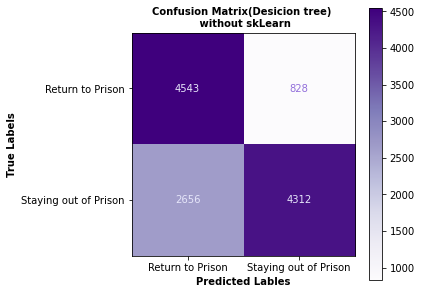

In [23]:

confusion_matrix = make_confusion_matrix(encoded_test_data[:,-1], predicted_labels)
plot_confusion_matrix(confusion_matrix, ['Return to Prison', 'Staying out of Prison'], title = 'Confusion Matrix(Desicion tree) \n without skLearn')


---
## Part2.
### Random Forest

#### Making random forest - algorithm : ID3 -  K : 3

In [24]:
def ID3_random_forest(train_data, max_depth, threshold, k):

    root = Node(data = train_data)
    if not len(np.array(root.data)) == 0:
      if (root.data.T[-1].all() == True):
        root.label = 1
        return root
      if (root.data[-1].any() == False):
        root.label = 0
        return root

      if(max_depth == 0):
        root.label = 1*((root.data[-1] == 1).sum() > (root.data.T[-1] == 0).sum())
        return root
    else : return root
    attribute = find_best_attribute(root, threshold)
    new_attribute = attribute + int(k*SIZE)
    root.attributes = new_attribute
    if(len(threshold[new_attribute]) == 2):
      root.child = np.append(root.child, [ID3_random_forest(np.array([data for data in train_data if data[attribute] == threshold[new_attribute][0]]), max_depth-1, threshold, k)], axis = 0)
      root.child = np.append(root.child, [ID3_random_forest(np.array([data for data in train_data if data[attribute] == threshold[new_attribute][1]]), max_depth-1, threshold, k)], axis = 0)
    else:
      root.child = np.append(root.child, [ID3_random_forest(np.array([data for data in train_data if data[attribute] == threshold[new_attribute][0]]), max_depth-1, threshold, k)], axis = 0)
      root.child = np.append(root.child, [ID3_random_forest(np.array([data for data in train_data if data[attribute] == threshold[new_attribute][1]]), max_depth-1, threshold, k)], axis = 0)
      root.child = np.append(root.child, [ID3_random_forest(np.array([data for data in train_data if data[attribute] == threshold[new_attribute][2]]), max_depth-1, threshold, k)], axis = 0)
    return root

In [27]:
K = 3
SIZE = 11/K
#np.random.shuffle(encoded_train_data.T[:, :-1])
final_tree = [ID3_random_forest(np.column_stack((encoded_train_data[:, int(k*SIZE):int((k+1)* SIZE)], encoded_train_data[:,-1])), 3, threshold, k) for k in range(K)]

final_predictions = []
for en in range(len(encoded_test_data)):
  predictions = [(move_along_tree(encoded_train_data[en], final_tree[k], threshold)) for k in range(K)]
  final_predictions.append(1*((np.array(predictions) == 1).sum() > (np.array(predictions) == 0).sum()))


In [28]:
print('Accuracy of Random Forest with k = ', K , 'is: %% %1.2f' %(calculate_acc(final_predictions, encoded_test_data)))

Accuracy of Random Forest with k =  3 is: % 58.38


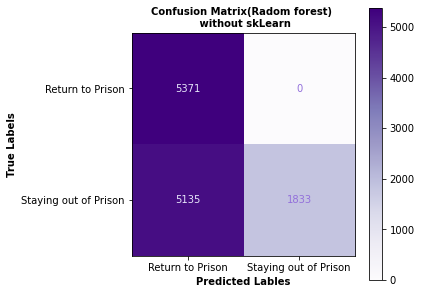

In [29]:
confusion_matrix = make_confusion_matrix(encoded_test_data[:,-1], final_predictions)
plot_confusion_matrix(confusion_matrix, ['Return to Prison', 'Staying out of Prison'], title = 'Confusion Matrix(Radom forest) \n without skLearn')

---
## Part3.
### Using sklearn

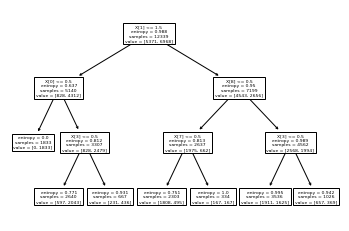

In [30]:

clf = tree.DecisionTreeClassifier(criterion = "entropy", random_state = 0, max_depth = 3)
clf = clf.fit(encoded_train_data[:,:-1], encoded_test_data[:,-1])
tree.plot_tree(clf);

In [31]:
y_pred = clf.predict(encoded_test_data[:,:-1])
accuracy = (y_pred == encoded_test_data[:, -1].astype(int)).mean()
print('Accuracy of Decision Tree using sklearn is: %% %1.2f' %(accuracy*100))

Accuracy of Decision Tree using sklearn is: % 71.76


In [32]:
def plot_confusion_matrix_sk(clf, test_data, test_label, matrix_labels, matrix_title):
  disp = plotConfustionMatrix(clf, test_data, test_label, display_labels = matrix_labels, cmap=plt.cm.Purples)
  disp.ax_.set_title(matrix_title)
  plt.show()

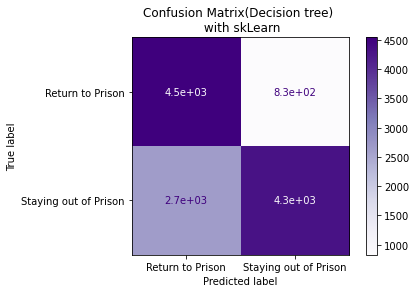

In [33]:
plot_confusion_matrix_sk(clf, encoded_train_data[:,:-1], encoded_test_data[:,-1], ['Return to Prison', 'Staying out of Prison'],  'Confusion Matrix(Decision tree) \n with skLearn')

In [37]:
clf_rf = RandomForestClassifier(random_state = 0, max_depth = 3)
clf_rf = clf_rf.fit(encoded_train_data[:,:-1], encoded_test_data[:,-1])

In [38]:
y_pred = clf_rf.predict(encoded_test_data[:,:-1])
accuracy_rf = (y_pred == encoded_test_data[:, -1]).mean()
print('Accuracy of Random Forest using sklearn is: %% %1.2f' %(accuracy_rf*100))

Accuracy of Random Forest using sklearn is: % 71.92


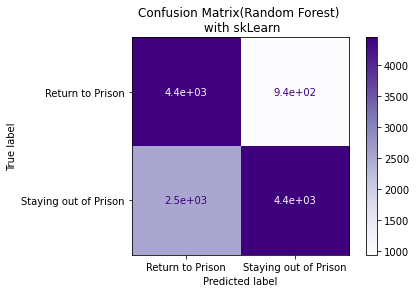

In [36]:
plot_confusion_matrix_sk(clf_rf, encoded_train_data[:,:-1], encoded_test_data[:,-1], ['Return to Prison', 'Staying out of Prison'],  'Confusion Matrix(Random Forest) \n with skLearn')